## <center><font color=green> Activity2: Workflow of Evaluating a Medical AI Model with Pytorch </font></center>

**Author(s)**: [Zhehua Mao](z.mao@ucl.ac.uk), [Miguel Xochicale](m.xochicale@ucl.ac.uk)   
**Contributor(s)**: Steve Thompson, Sophia Bano, Matt Clarkson at UCL; and Mikael Brudfors at NVIDIA

## Setting up google colabs
* You will need to first log in to your google account.
* Open notebook in google-colabs [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zNmljc-ppn_0RZvppI3Vz7rX3uA8msPd/view?usp=sharing)
* Setting up the runtime type to GPU by clicking: Edit > Notebook settings > Python 3 > T4 GPU (other any other GPU or TPU)
* After that you can click `Runtime` -> `Run all` **OR** run the codes step by step by clicking `Run cell` button in the notebook.

# Introduction



Now that we have a trained model for our segmentation task! But how do we know if our segmentation model performs well? In other words, how do we evaluate our model performance?

In this hands-on activity, you will go through general steps of evaluating our trained model in practice. Here we use ColonSegNet as an example. We will see the performance of the model on the Kvasir-SEG dataset [1], using the ColonSegNet model architecture [2].

[1] Jha, Debesh, Pia H. Smedsrud, Michael A. Riegler, Pål Halvorsen, Thomas de Lange, Dag Johansen, and Håvard D. Johansen, "Kvasir-seg: A segmented polyp dataset" Proceedings of the International Conference on Multimedia Modeling, pp. 451-462, 2020.

[2] Jha D, Ali S, Tomar NK, Johansen HD, Johansen D, Rittscher J, Riegler MA, Halvorsen P. Real-Time Polyp Detection, Localization and Segmentation in Colonoscopy Using Deep Learning. IEEE Access. 2021 Mar 4;9:40496-40510. doi: 10.1109/ACCESS.2021.3063716. PMID: 33747684; PMCID: PMC7968127.


# Preparing codes

In [ ]:
# change to workspace directory
import os
os.chdir('/content/')

In [ ]:
# clone the codes for ColonSegNEt
if not os.path.exists('ColonSegNet'):
  print('Cloning repository...')
  !git clone https://github.com/ZH-Mao/ColonSegNet.git

Cloning repository...
Cloning into 'ColonSegNet'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 160 (delta 78), reused 123 (delta 58), pack-reused 0
Receiving objects: 100% (160/160), 26.89 MiB | 29.39 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
# Change to the folder of ColonSegNet
os.chdir('/content/ColonSegNet')
os.getcwd()

'/content/ColonSegNet'

# Import dependencies

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-6bloho3f
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-6bloho3f
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit dd070546eda51e21ab772ee6f14807c7f5b1548b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405482 sha256=9158d343e8e4b2f213d87dfc73d2b8e24ddd2a810409755aa4b701c878af35fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-nj055nof/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [ ]:
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from data import load_data, KvasirDataset
from torch.utils.data import DataLoader
from sklearn.metrics import (
    jaccard_score, f1_score, recall_score, precision_score, accuracy_score, fbeta_score)

from model import CompNet
from utils import create_dir, seeding, make_channel_last
from data import load_data
from crf import apply_crf

# Download dataset

In [ ]:
if not os.path.exists('Kvasir-SEG'):
    print('Downloading data...')
    !wget https://datasets.simula.no/downloads/kvasir-seg.zip
    !unzip -q kvasir-seg.zip && rm kvasir-seg.zip
    !mv train.txt val.txt ./Kvasir-SEG

--2023-11-06 10:30:31--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  17.7MB/s    in 2.5s    

2023-11-06 10:30:35 (17.7 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



In [ ]:
# Define a function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name)
        plt.imshow(image)
    plt.show()

In [ ]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)

    ## Score
    score_jaccard = jaccard_score(y_true, y_pred, average='binary')
    score_f1 = f1_score(y_true, y_pred, average='binary')
    score_recall = recall_score(y_true, y_pred, average='binary')
    score_precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    score_acc = accuracy_score(y_true, y_pred)
    score_fbeta = fbeta_score(y_true, y_pred, beta=1.0, average='binary', zero_division=1)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_fbeta]

def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

# Data loader

In [ ]:
# Define datasets
path = "/content/ColonSegNet/Kvasir-SEG"
(train_x, train_y), (test_x, test_y) = load_data(path)

print(f"Dataset Size:\nTest: {len(test_x)}\n")

# Define Dataset
test_dataset = KvasirDataset(test_x, test_y, size = (512, 512))
# Define test data loader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2
)

Dataset Size:
Test: 120



# Load trained model

In [ ]:
""" Hyperparameters """
size = (512, 512)
checkpoint_path = "./checkpoint.pth"

""" Directories """
create_dir("results/mix")
create_dir("results/mask")

""" Load the checkpoint """
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CompNet()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

CompNet(
  (e1): EncoderBlock(
    (residual_block1): ResidualBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
        )
        (sigmoid): Sigmoid()
      )
      (relu): ReLU(inplace=True)
    )
    (strided_conv): StridedConvBlock(
      (conv): Conv2d(64, 64, kernel_s

# Inference on one image in the test dataset

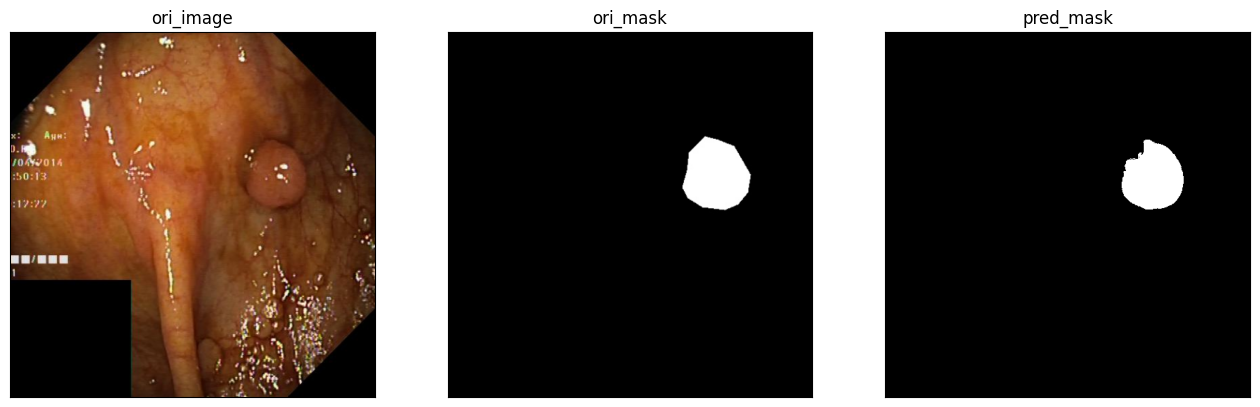

In [ ]:
import random

i = random.randint(0, len(test_x)-1)

x, y = test_x[i], test_y[i]
name = y.split("/")[-1].split(".")[0]

## Image
image = cv2.imread(x, cv2.IMREAD_COLOR)

image1 = cv2.resize(image, size)
ori_img1 = image1
image1 = np.transpose(image1, (2, 0, 1))
image1 = image1/255.0
image1 = np.expand_dims(image1, axis=0)
image1 = image1.astype(np.float32)
image1 = torch.from_numpy(image1)
image1 = image1.to(device)

## Mask
mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

mask1 = cv2.resize(mask, size)
ori_mask1 = mask1
mask1 = np.expand_dims(mask1, axis=0)
mask1 = mask1/255.0
mask1 = np.expand_dims(mask1, axis=0)
mask1 = mask1.astype(np.float32)
mask1 = torch.from_numpy(mask1)
mask1 = mask1.to(device)

with torch.no_grad():
    pred_y1 = torch.sigmoid(model(image1))
    """ Predicted Mask """
    pred_y1 = pred_y1[0].cpu().numpy()
    pred_y1 = np.squeeze(pred_y1, axis=0)
    pred_y1 = pred_y1 > 0.5
    pred_y1 = pred_y1.astype(np.int32)
    pred_y1 = apply_crf(ori_img1, pred_y1)
    pred_y1 = pred_y1 * 255
    pred_y1 = np.array(pred_y1, dtype=np.uint8)

ori_img1 = ori_img1
ori_mask1 = mask_parse(ori_mask1)
pred_y1 = mask_parse(pred_y1)
sep_line = np.ones((size[0], 10, 3)) * 255

visualize(
    ori_image = cv2.cvtColor(ori_img1, cv2.COLOR_BGR2RGB),
    ori_mask=ori_mask1,
    pred_mask = pred_y1
)

# Inference on all images in the test dataset

In [ ]:
""" Testing """
metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in enumerate(tqdm(zip(test_x, test_y), total=len(test_x))):
        name = y.split("/")[-1].split(".")[0]

        ## Image
        image = cv2.imread(x, cv2.IMREAD_COLOR)

        image1 = cv2.resize(image, size)
        ori_img1 = image1
        image1 = np.transpose(image1, (2, 0, 1))
        image1 = image1/255.0
        image1 = np.expand_dims(image1, axis=0)
        image1 = image1.astype(np.float32)
        image1 = torch.from_numpy(image1)
        image1 = image1.to(device)

        ## Mask
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        mask1 = cv2.resize(mask, size)
        ori_mask1 = mask1
        mask1 = np.expand_dims(mask1, axis=0)
        mask1 = mask1/255.0
        mask1 = np.expand_dims(mask1, axis=0)
        mask1 = mask1.astype(np.float32)
        mask1 = torch.from_numpy(mask1)
        mask1 = mask1.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            pred_y1 = torch.sigmoid(model(image1))
            end_time = time.time() - start_time
            time_taken.append(end_time)
            # print("{} - {:.10f}".format(name, end_time))

            """ Evaluation metrics """
            score = calculate_metrics(mask1, pred_y1)
            metrics_score = list(map(add, metrics_score, score))

            """ Predicted Mask """
            pred_y1 = pred_y1[0].cpu().numpy()
            pred_y1 = np.squeeze(pred_y1, axis=0)
            pred_y1 = pred_y1 > 0.5
            pred_y1 = pred_y1.astype(np.int32)
            pred_y1 = apply_crf(ori_img1, pred_y1)
            pred_y1 = pred_y1 * 255
            pred_y1 = np.array(pred_y1, dtype=np.uint8)

        ori_img1 = ori_img1
        ori_mask1 = mask_parse(ori_mask1)
        pred_y1 = mask_parse(pred_y1)
        sep_line = np.ones((size[0], 10, 3)) * 255

        tmp = [
            ori_img1, sep_line,
            ori_mask1, sep_line,
            pred_y1
        ]

        cat_images = np.concatenate(tmp, axis=1)
        cv2.imwrite(f"results/mix/{name}.png", cat_images)
        cv2.imwrite(f"results/mask/{name}.png", pred_y1)

100%|██████████| 120/120 [01:28<00:00,  1.36it/s]


# Understanding Evaluation Metrics in Medical Image Segmentation

<div>
<img src="https://drive.google.com/uc?export=view&id=17J3VHNndz9qI0MD_7zDJdvJxh1AvnXVA" width="700"/>
</div>

5 evaluation metrics are widely used for evaluating segmentation performance:


1.   Precision
2.   Recall (Sensitivity)
3.   Accuracy/Rand index
4.   Dice coefficient
5.   Jaccard index (IoU)

You can find detials about how to calculate them [here](https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f#:~:text=Jaccard%20index%20(IoU),false%20negative%20(FN)%20predictions.).

In [ ]:
# output evaluation metrics
jaccard = metrics_score[0]/len(test_x)
f1 = metrics_score[1]/len(test_x)
recall = metrics_score[2]/len(test_x)
precision = metrics_score[3]/len(test_x)
acc = metrics_score[4]/len(test_x)
f2 = metrics_score[5]/len(test_x)

print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f}")

mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("Mean FPS: ", mean_fps)

Jaccard: 0.7239 - F1: 0.8206 - Recall: 0.8496 - Precision: 0.8435 - Acc: 0.9493 - F2: 0.8206
Mean FPS:  145.43020272300686


# Question:
<div>
<img src="https://drive.google.com/uc?export=view&id=17F9TTjlpGa5H4BeFzDGd8e0VzWrydtTq" width="400"/>
</div>

In this example, we did not use a dataloader. Can you refer to our training process and use the test dataloader during inference?